In [1]:
from Vissim_env_class import environment
from Actor_critic_class import ACAgent
from MasterAC_Agent import MasterAC_Agent
from MasterDQN_Agent import MasterDQN_Agent

# Network Specific Libraries
from Balance_Functions import balance_dictionary

# General Libraries
import numpy as np 
import pylab as plt
import os
import shutil
import csv
import pandas as pd
import json
import sqlite3

%load_ext sql
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Balance RL DQN Integrated

In [2]:
model_name  = 'Balance_integrated'
vissim_working_directory = 'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Vissim\\'
#vissim_working_directory = "E:\\OneDrive - University of Warwick\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Vissim"

# State the internal IDs of the intersections used during training, according to topology
intersection_ids = ["1_2_4", "1_2_4", "3", "1_2_4", "5", "6", "7",\
                    "8", "9", "10", "11_12", "11_12", "13", "14"]

## Simulation Parameters
Random_Seed = 44
sim_length = 10801
agent_type = "DuelingDDQN"
actions = 'default_actions'     # 'default_actions' or 'all_actions'

## DQN Hyperaramenters
episodes = 100
copy_weights_frequency = 10
timesteps_per_second = 1
PER_activated = True
memory_size = 5000
batch_size = 256
batches_per_episode = 10

alpha = 0.001
gamma = 0.95

# Load balance dictionary
Balance_dictionary = balance_dictionary(agent_type)

# State session ID
Session_ID = model_name + "_" + actions + "_" + str(episodes) + "_" + str(sim_length-1) + "_" + agent_type + "_delay"
print("Session ID: {}".format(Session_ID))

Session ID: Balance_integrated_default_actions_100_10800_DuelingDDQN_delay


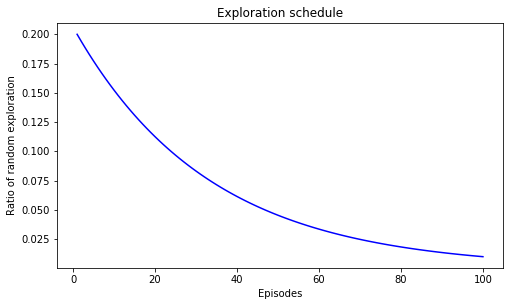

In [3]:
# Exploration Schedule ("linear" or "geometric")
exploration_schedule = "geometric"
epsilon_start = 0.2
epsilon_end   = 0.01
epsilon_min   = 0.01

def choose_schedule(exploration_schedule, espilon_start, epsilon_end, epsilon_min, episodes):
    if exploration_schedule == "linear":
        epsilon_decay = 1.2*(epsilon_end - epsilon_start)/(episodes-1)
        epsilon_sequence = [epsilon_start + epsilon_decay * entry for entry in range(episodes+1)]
        epsilon_sequence = [epsilon_min if entry < epsilon_min else entry for entry in epsilon_sequence]
    elif exploration_schedule == "geometric":
        epsilon_decay = np.power(epsilon_end/epsilon_start, 1./(episodes-1)) # Geometric decay
        epsilon_sequence = [epsilon_start * epsilon_decay ** entry for entry in range(episodes+1)]
        epsilon_sequence = [epsilon_min if entry < epsilon_min else entry for entry in epsilon_sequence]
    elif exploration_schedule == "entropy":
        pass
    else:
        print("ERROR: Unrecognized choice of exploration schedule.")
        
    # Plotting exploration schedule
    plt.figure(figsize=(8,4.5))
    x_series = np.array(range(1,episodes+1))
    y_series = epsilon_sequence[0:episodes]
    plt.plot(x_series, y_series, '-b')
    plt.xlabel('Episodes')
    plt.ylabel('Ratio of random exploration')
    plt.title('Exploration schedule')
    plt.show()
    return(epsilon_sequence)

epsilon_sequence = choose_schedule(exploration_schedule, epsilon_start, epsilon_end, epsilon_min, episodes)


In [ ]:
## Gather files from pretrained Balance_intX Runs

# Re-create the Intersection IDs used during training
single_intersection_agent_ids = ['Balance_int'+ int_id for int_id in intersection_ids]
# Re-create the Session IDs used during training
single_intersection_session_ids = [ agent_id + "_" + actions + "_" + str(episodes) + "_" + str(sim_length-1) + "_" + agent_type + "_delay"
 for agent_id in single_intersection_agent_ids]

# Use the two previous set of strings to point to the location of the agent files
agents_sources_origin = [os.path.join(vissim_working_directory, single_intersection_agent_ids[idx],\
                                   "Agents_Results", agent_type, session_id) for idx, session_id in enumerate(single_intersection_session_ids)]

# Set the destination path into the new model
# Intersections that trained together are now split into individual forlders
agents_sources_destination = [os.path.join(vissim_working_directory, "Balance_Integrated", "Agents_source",\
                                         agent_type, Session_ID,"Agent{}".format(idx)) for idx, session_id in enumerate(single_intersection_session_ids)]

# Check if output folders exist, if they do not, then create them
for folder in agents_sources_destination:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Copy all training files from their origin to the Balance_integrated archive
for idx, (origin, destination) in enumerate(zip(agents_sources_origin, agents_sources_destination)):
    print("Agent {}".format(idx))
    #print("Listing files in:", origin)
    
    # List all files in origin folder
    files_in_folder = os.listdir(origin)
    print("Copying files...")
    
    # Copy them one by one
    for file in files_in_folder:
        shutil.copy(os.path.join(origin,file), destination)
print("All Files Successfully Copied.")

In [4]:
Balance_integrated_MultiDQN_Agents = MasterDQN_Agent(model_name, vissim_working_directory, sim_length, Balance_dictionary, actions,\
                gamma, alpha, agent_type, memory_size, PER_activated, batch_size, batches_per_episode, copy_weights_frequency, epsilon_sequence,\
                Random_Seed, timesteps_per_second, Session_ID, verbose = True)

INTERSECTION 0: SETTING UP AGENT
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 24)           216         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 24)           600         dense[0][0]                      
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 24)           600         dense_1[0][0]                    
_____________________________________________________________

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 24)           168         input_9[0][0]                    
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 24)           600         dense_48[0][0]                   
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 24)           600         dense_49[0][0]                   
____________________________________________________________________________________________

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_96 (Dense)                (None, 24)           96          input_17[0][0]                   
__________________________________________________________________________________________________
dense_97 (Dense)                (None, 24)           600         dense_96[0][0]                   
__________________________________________________________________________________________________
dense_100 (Dense)               (None, 24)           600         dense_97[0][0]                   
___________________________________________________________________________________________

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 7)]          0                                            
__________________________________________________________________________________________________
dense_144 (Dense)               (None, 24)           192         input_25[0][0]                   
__________________________________________________________________________________________________
dense_145 (Dense)               (None, 24)           600         dense_144[0][0]                  
__________________________________________________________________________________________________
dense_148 (Dense)               (None, 24)           600         dense_145[0][0]                  
___________________________________________________________________________________________

In [5]:
Balance_integrated_MultiDQN_Agents.load_isolated(100, best = True)

Loading Agents....
Independently Pre-Trained Agent 0, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 1, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 2, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 3, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 4, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 5, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 6, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 7, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 8, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 9, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 10, Architecture, Optimizer and Memory.
Success.
Independently Pre-Trained Agent 11, Architecture, Optimizer and Memory.
Success.
Independently Pre-T

In [ ]:
Balance_integrated_MultiDQN_Agents.demo()

In [7]:
Balance_integrated_MultiDQN_Agents.save_integrated(episodes)

Saving architecture, weights and optimizer state for agent-0
Dumping agent-0 memory into pickle file
Dumping Training Results into pickle file.
Dumping Loss Results into pickle file.
Saving architecture, weights and optimizer state for agent-1
Dumping agent-1 memory into pickle file
Dumping Training Results into pickle file.
Dumping Loss Results into pickle file.
Saving architecture, weights and optimizer state for agent-2
Dumping agent-2 memory into pickle file
Dumping Training Results into pickle file.
Dumping Loss Results into pickle file.
Saving architecture, weights and optimizer state for agent-3
Dumping agent-3 memory into pickle file
Dumping Training Results into pickle file.
Dumping Loss Results into pickle file.
Saving architecture, weights and optimizer state for agent-4
Dumping agent-4 memory into pickle file
Dumping Training Results into pickle file.
Dumping Loss Results into pickle file.
Saving architecture, weights and optimizer state for agent-5
Dumping agent-5 memory i

Intersection 1
Agent 1: Training Loss and Average Reward during training successfuly saved to file:
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\Balance_integrated\Agents_Results\DuelingDDQN\Balance_integrated_default_actions_100_10800_DuelingDDQN_delay\Agent0/Agent1_Loss_average_reward.json
Intersection 1
Agent 1: Training Loss and Average Reward during training successfuly saved to file:
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\Balance_integrated\Agents_Results\DuelingDDQN\Balance_integrated_default_actions_100_10800_DuelingDDQN_delay\Agent1/Agent1_Loss_average_reward.json
Intersection 1
Agent 1: Training Loss and Average Reward during training successfuly saved to file:
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\Balance_integrated\Agents_Results\DuelingDDQN\Balance_integrated_default_actions_10

C:\Users\acabrejasegea\AppData\Local\Continuum\anaconda3\envs\vissim\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\acabrejasegea\AppData\Local\Continuum\anaconda3\envs\vissim\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Intersection 1
Agent 1: Training Loss and Average Reward during training successfuly saved to file:
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\Balance_integrated\Agents_Results\DuelingDDQN\Balance_integrated_default_actions_100_10800_DuelingDDQN_delay\Agent11/Agent1_Loss_average_reward.json
Intersection 1
Agent 1: Training Loss and Average Reward during training successfuly saved to file:
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\Balance_integrated\Agents_Results\DuelingDDQN\Balance_integrated_default_actions_100_10800_DuelingDDQN_delay\Agent12/Agent1_Loss_average_reward.json
Intersection 1
Agent 1: Training Loss and Average Reward during training successfuly saved to file:
C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\Balance_integrated\Agents_Results\DuelingDDQN\Balance_integrated_default_actions_

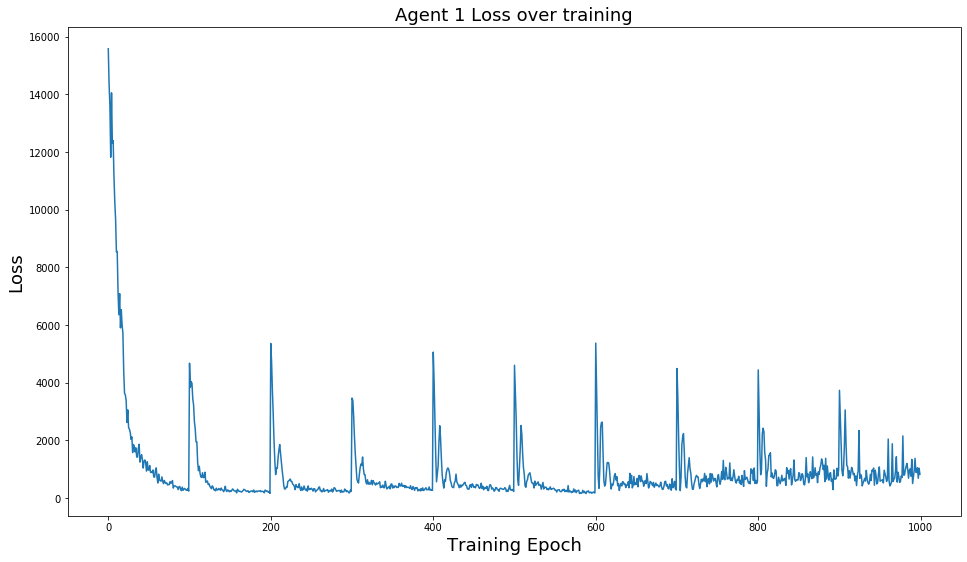

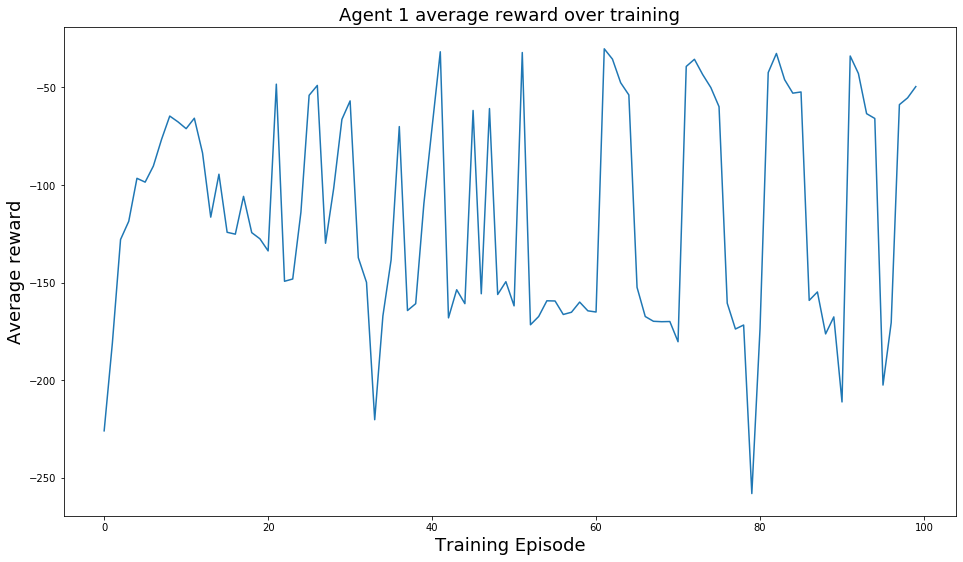

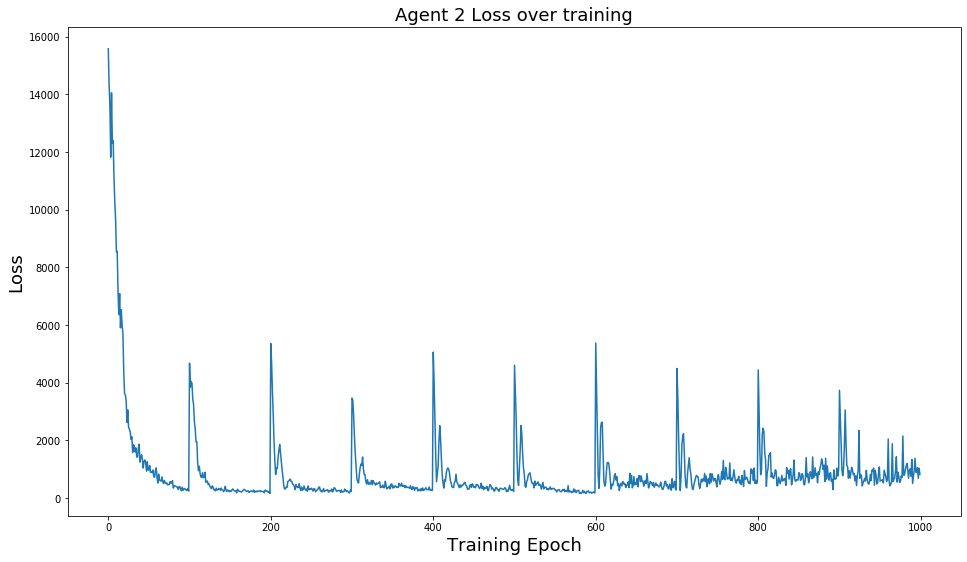

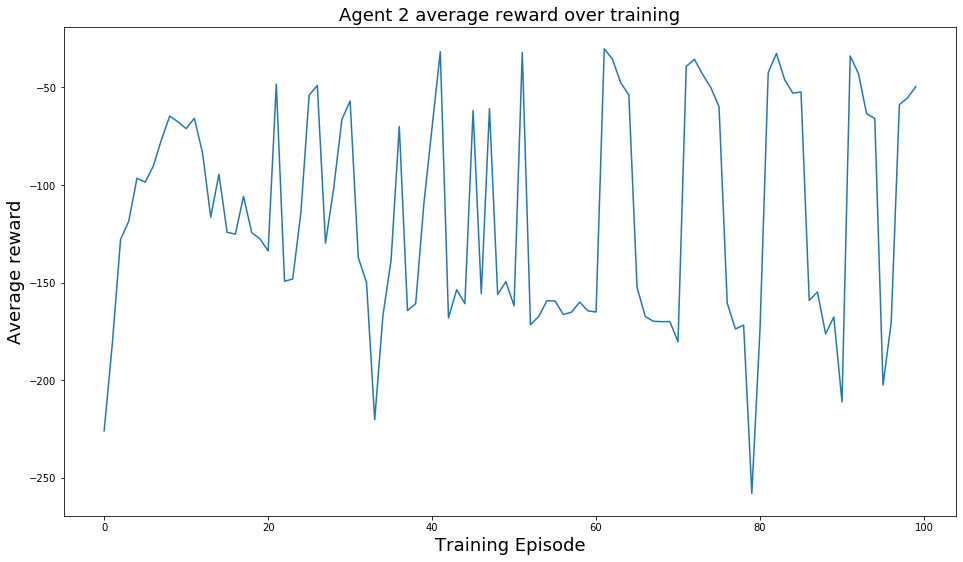

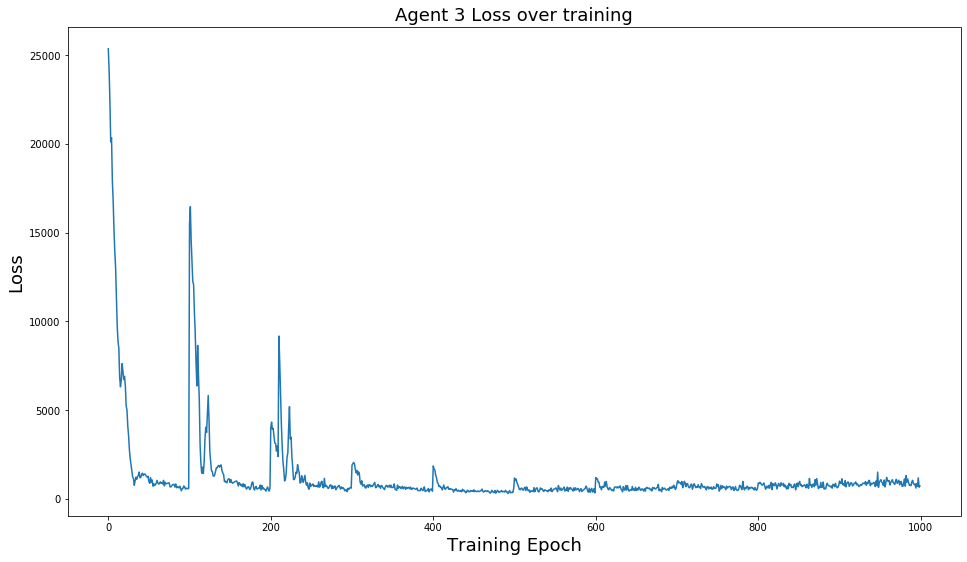

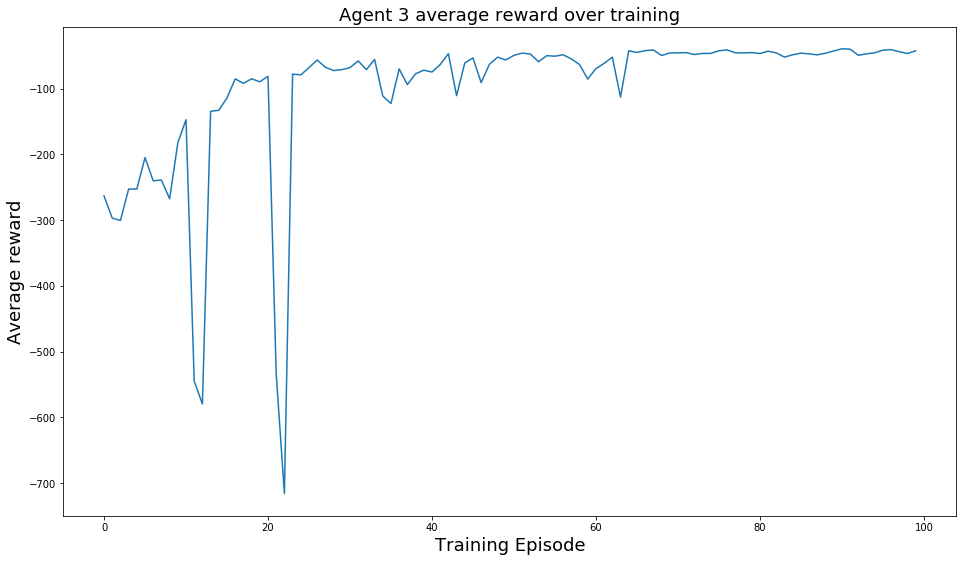

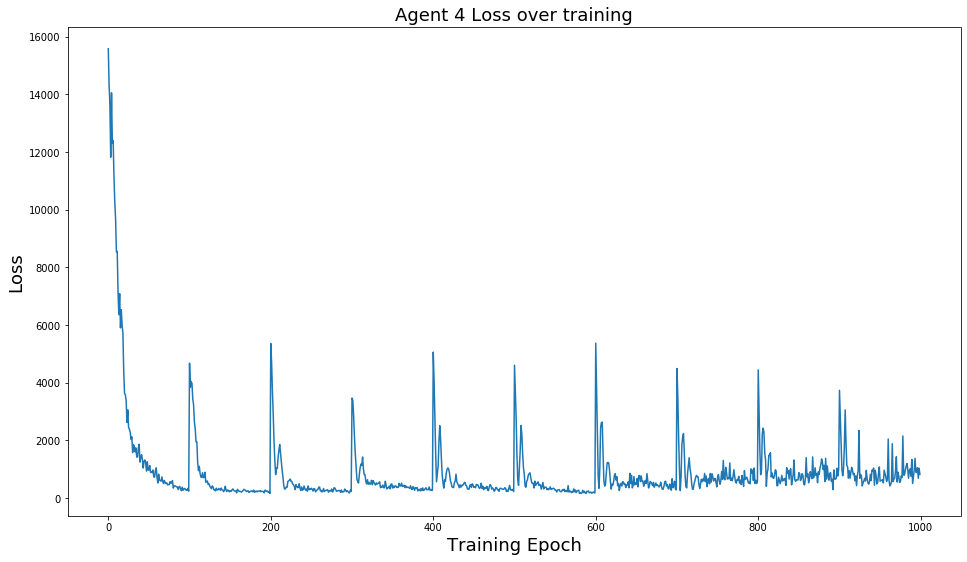

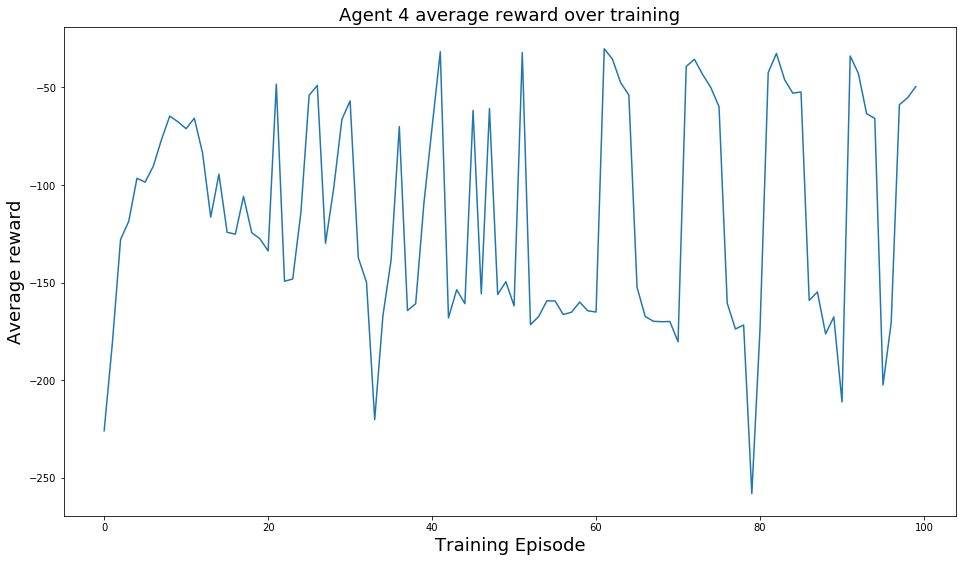

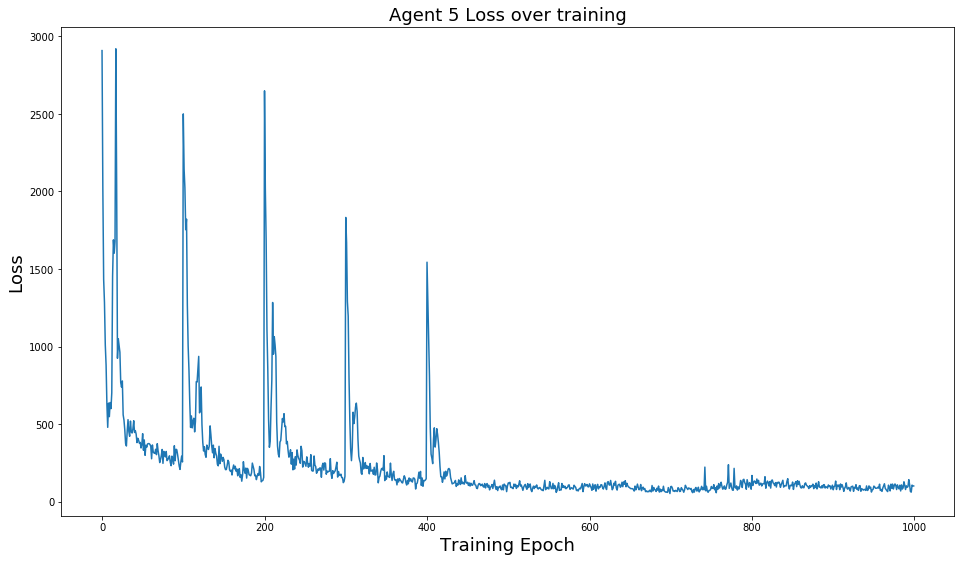

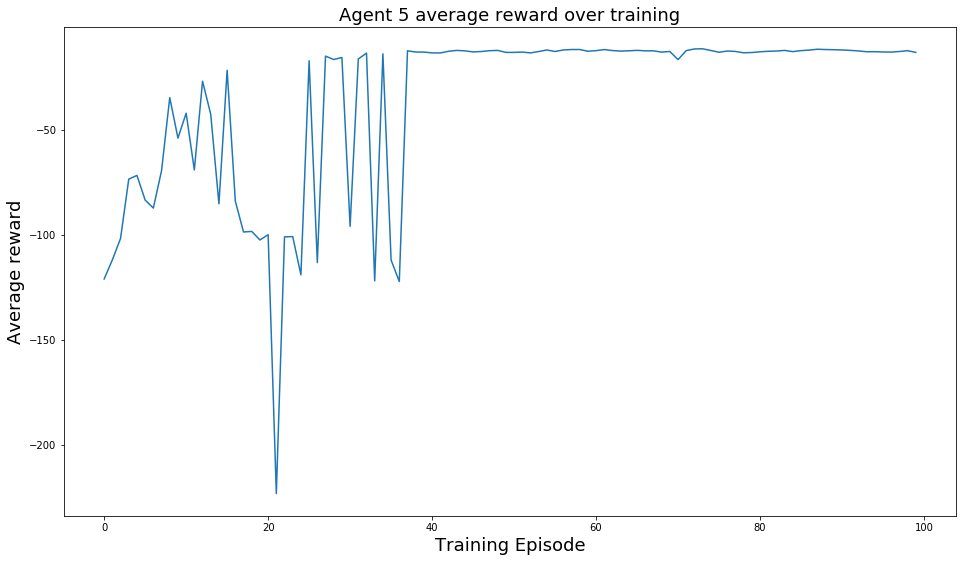

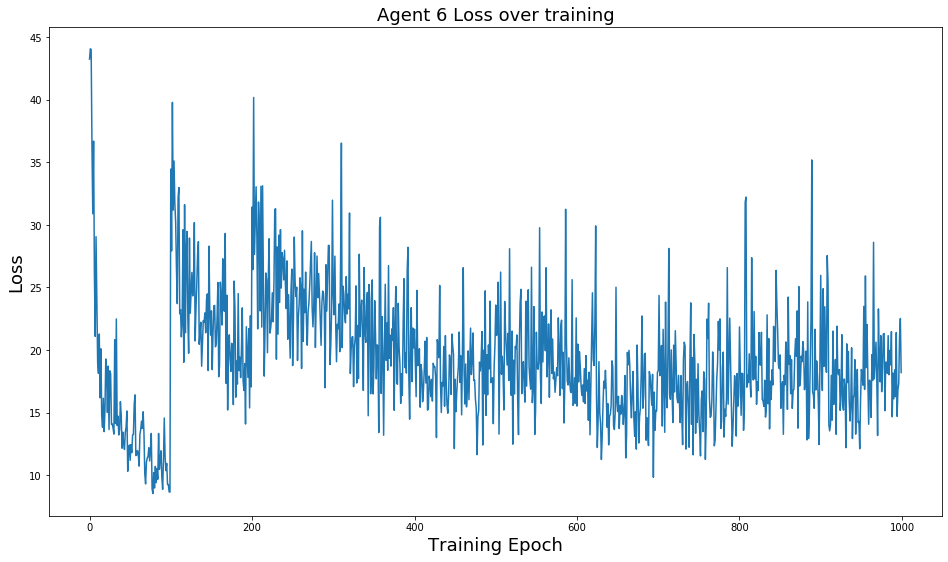

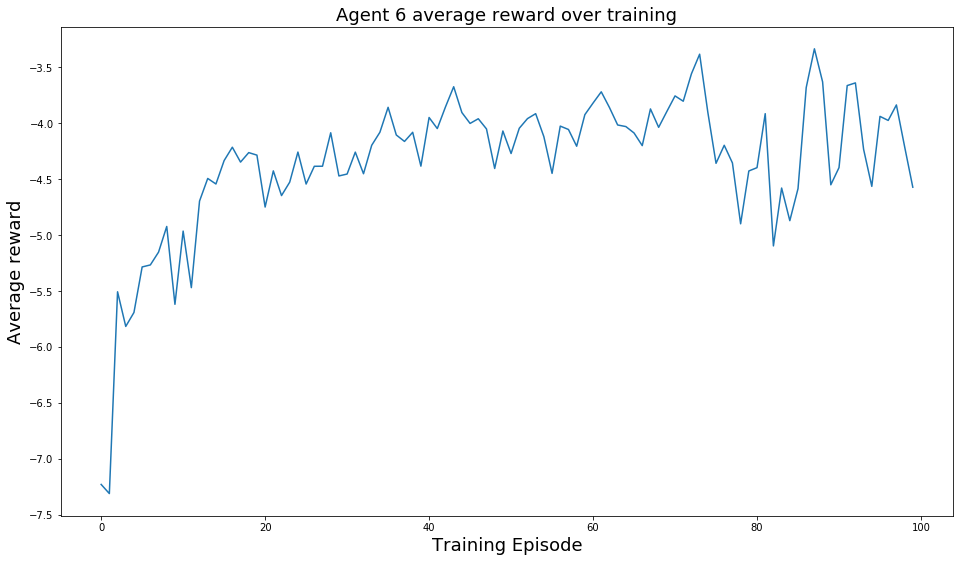

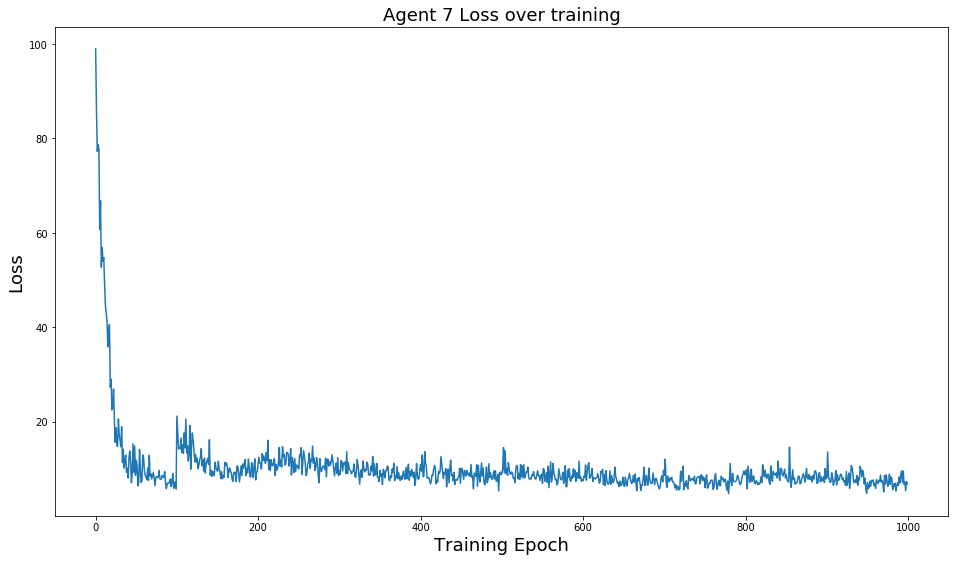

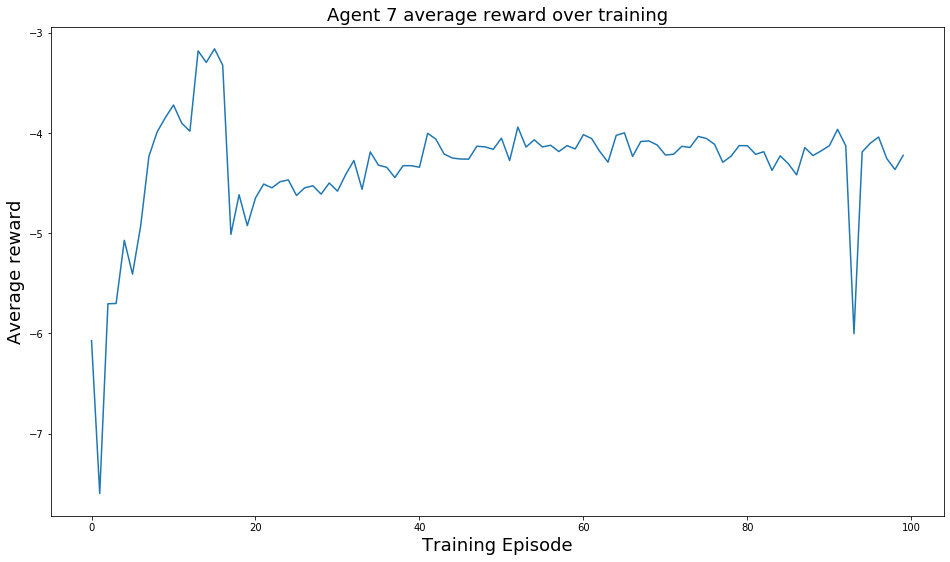

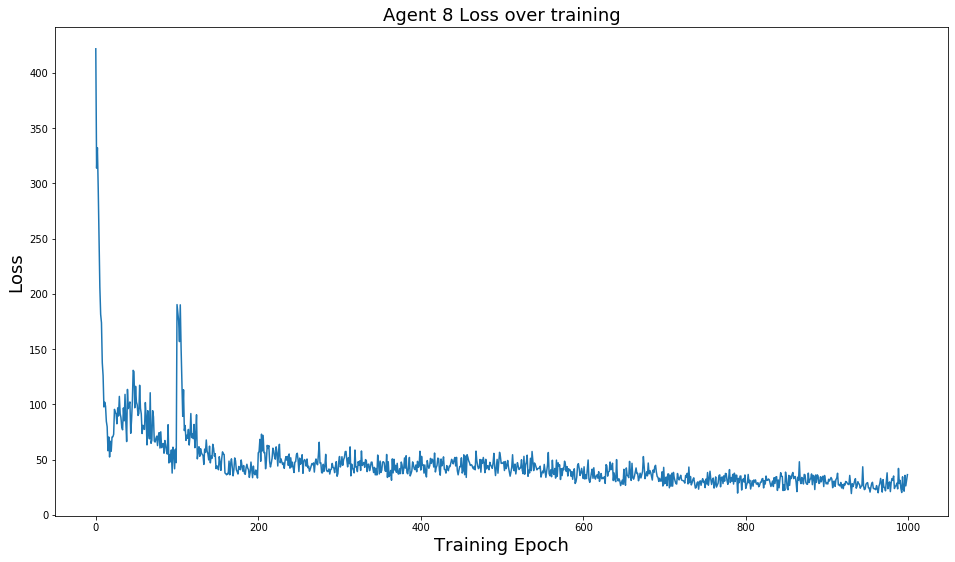

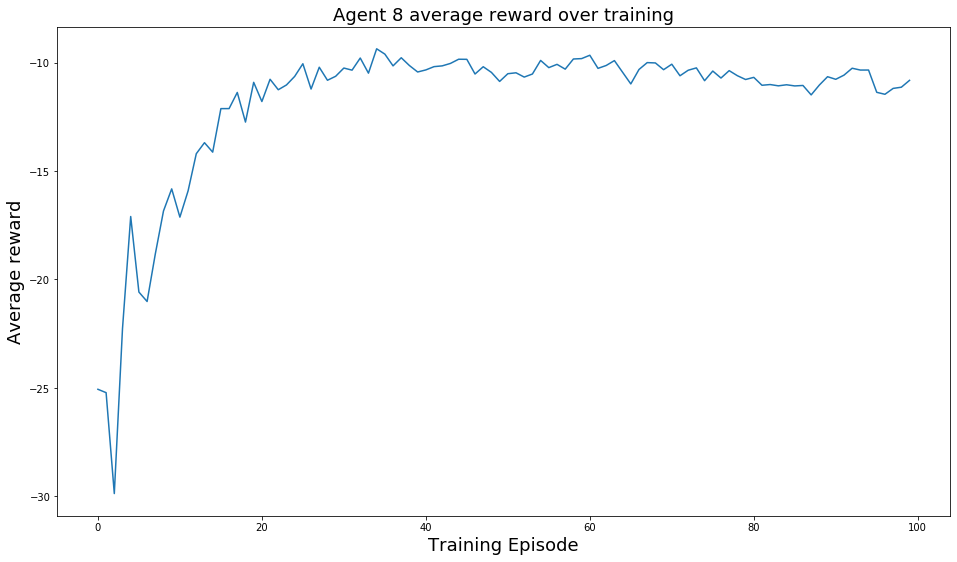

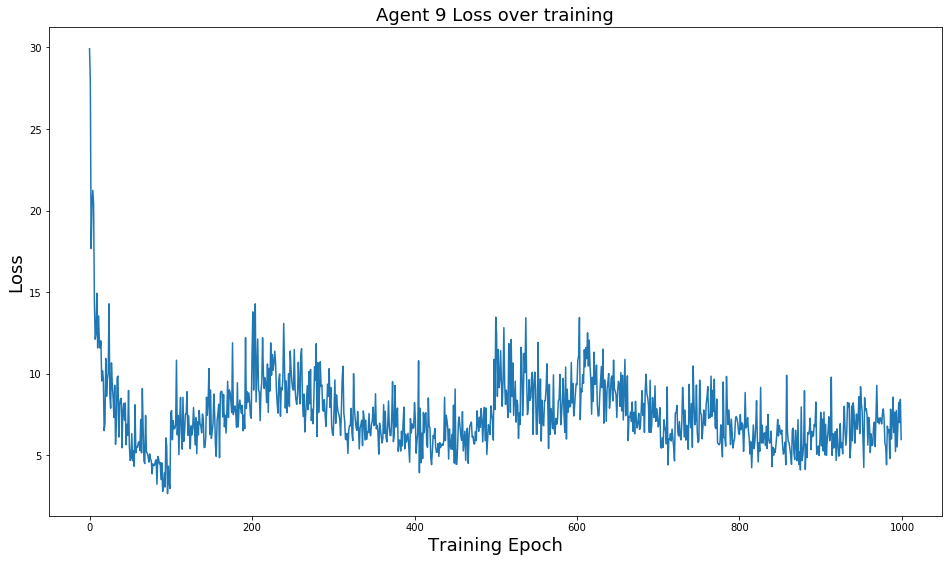

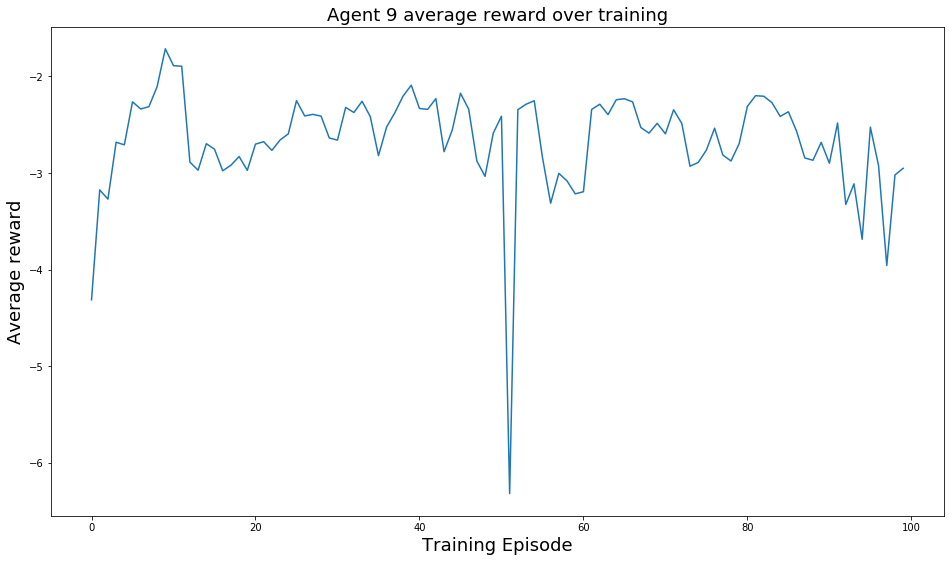

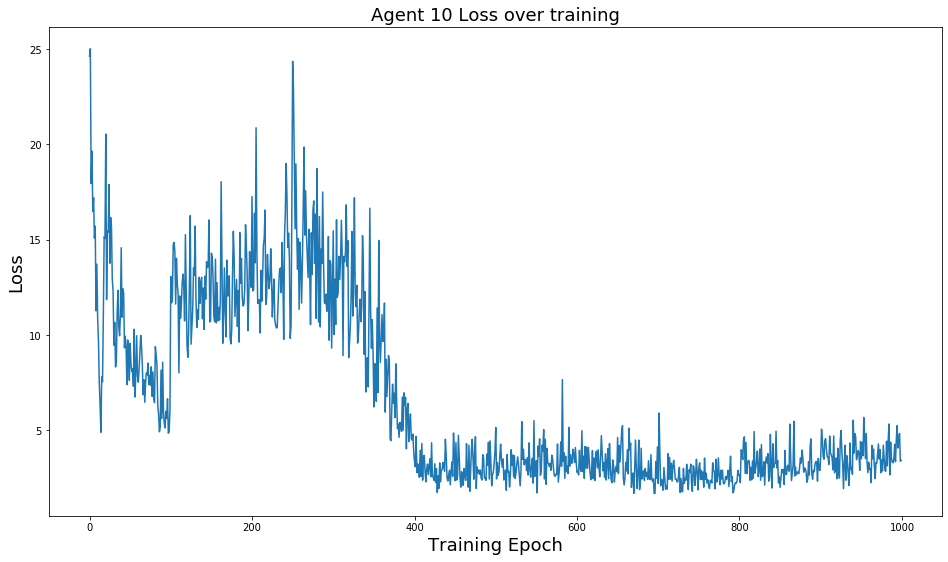

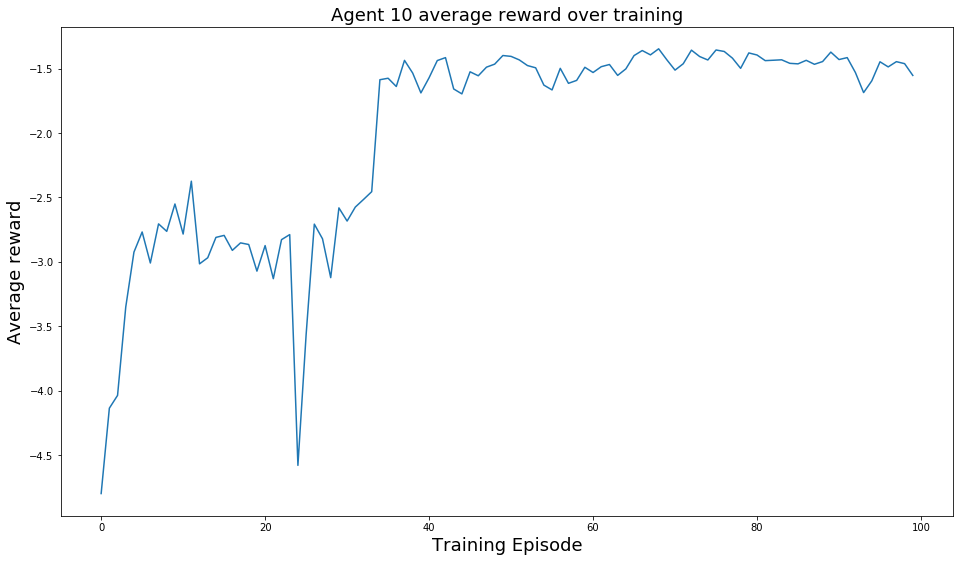

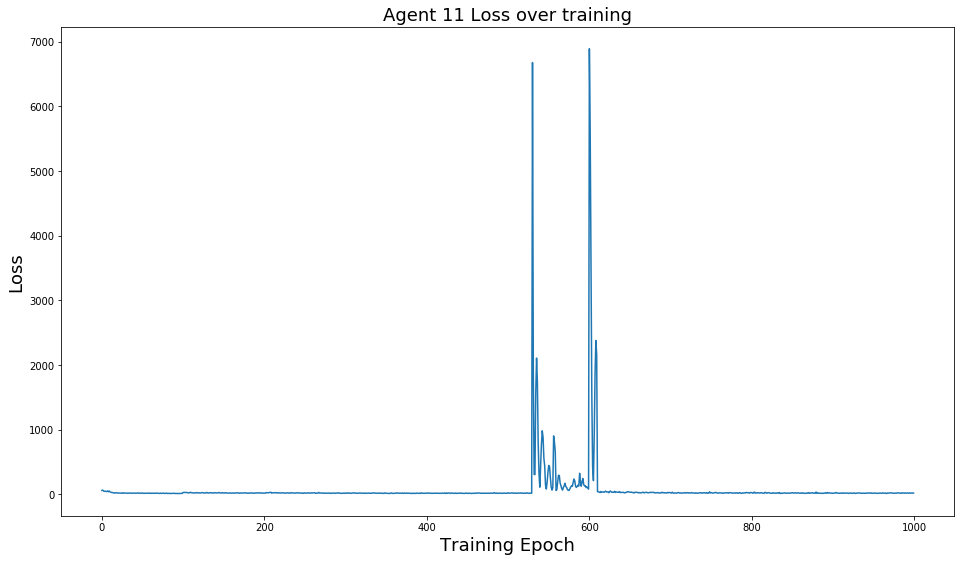

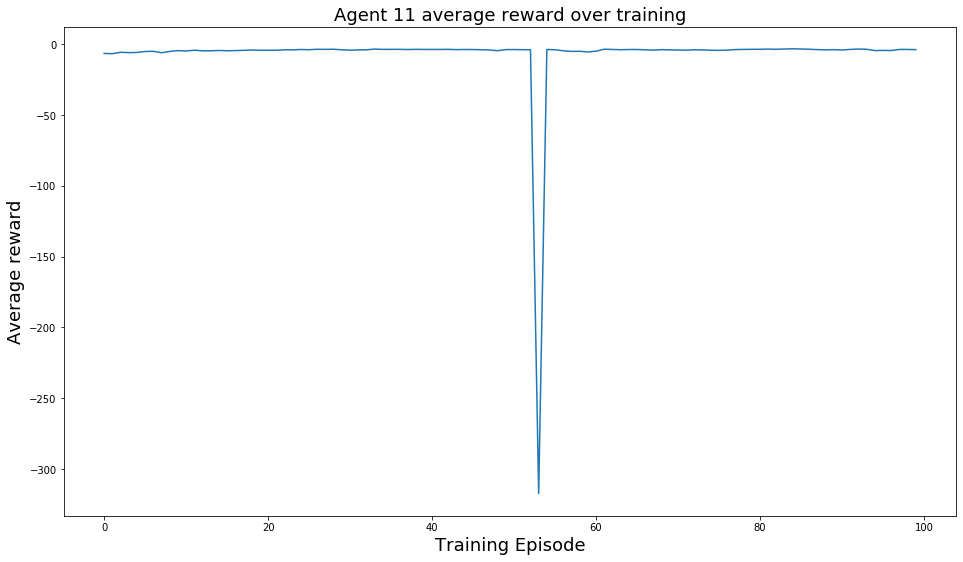

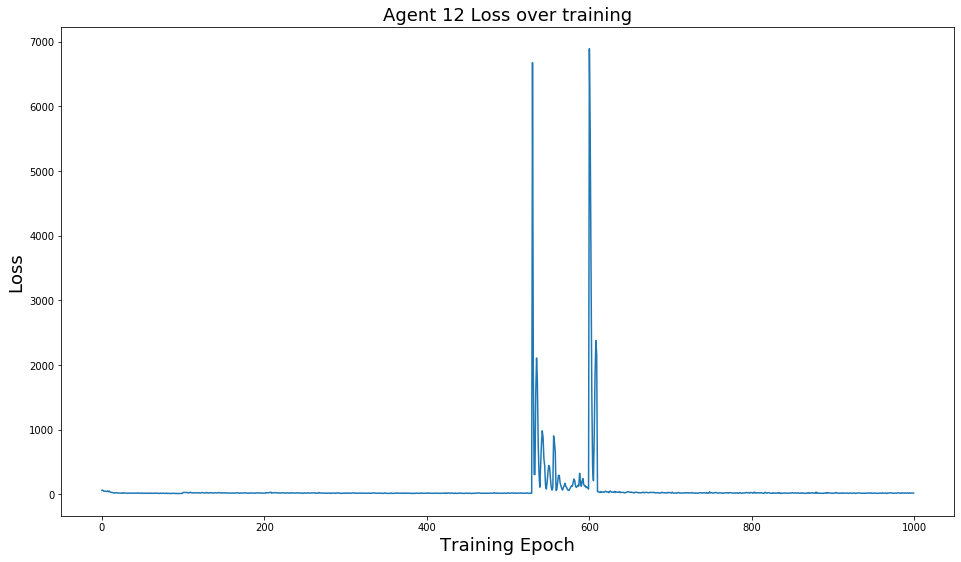

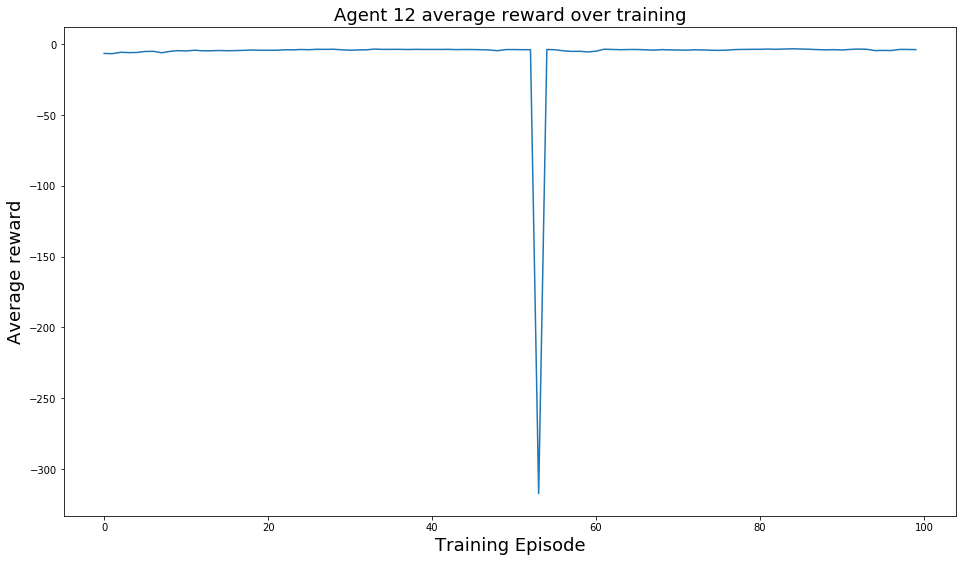

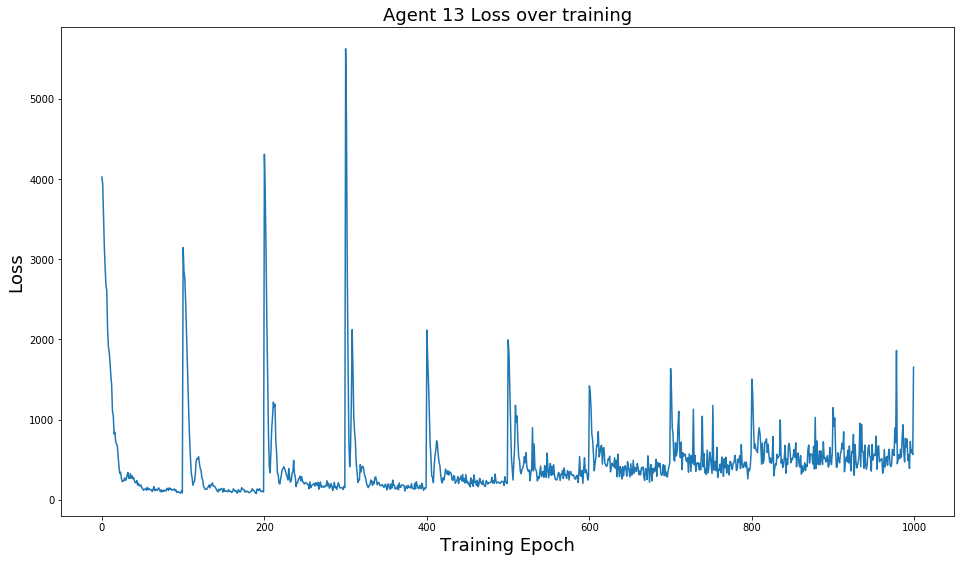

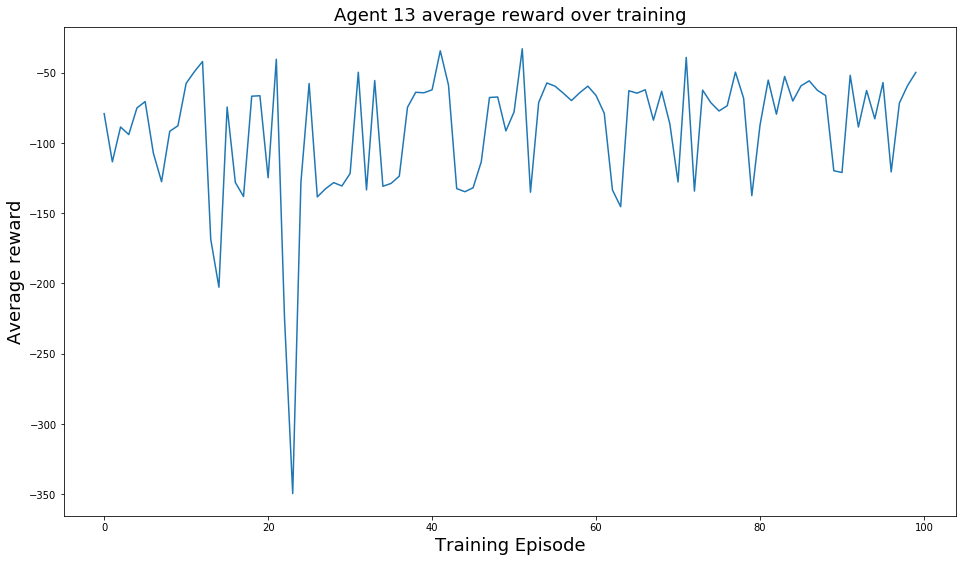

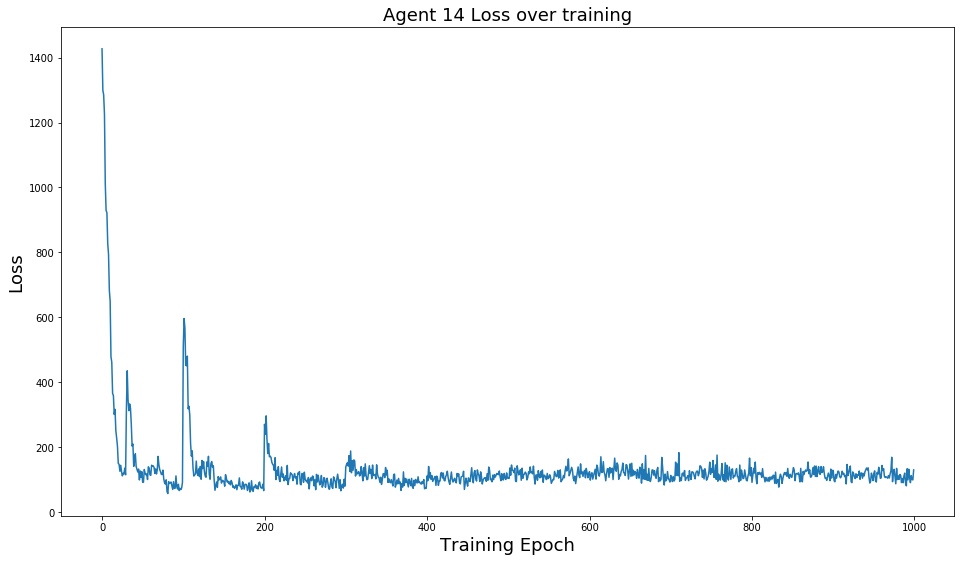

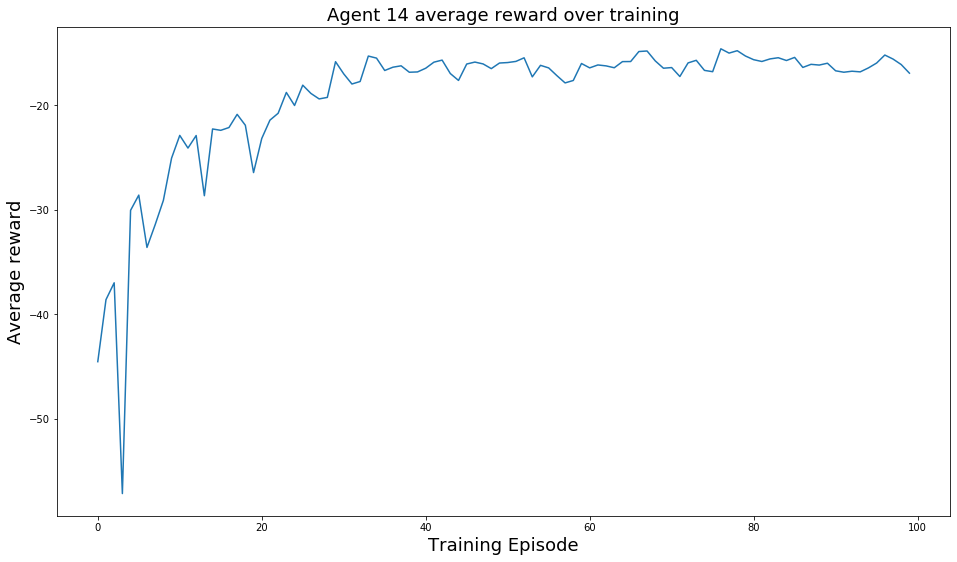

In [9]:
## AGENT TRAINING RESULTS
# Path to results folder

# Loop over each agent
for idx , agent in Balance_integrated_MultiDQN_Agents.Agents.items():
    results_path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type,\
                                Session_ID, "Agent{}".format(idx))

    intersection_number_in_vissim = Balance_integrated_MultiDQN_Agents.Agents[0].signal_id + 1
    print("Intersection "+str(intersection_number_in_vissim))
    
    ## SAVE TRAINING DATA TO JSON.
    json_filename = "Agent{}_Loss_average_reward.json".format(intersection_number_in_vissim)
    Loss_reward = dict()   
    # Loss dictionary
    for epoch, loss in enumerate(agent.loss):
        loss_dict = { epoch : loss }
    Loss_reward['Agent{} loss'.format(intersection_number_in_vissim)] = loss_dict
    # Reward dictionary            
    episode = [i for i in range(len(agent.reward_storage))]
    Loss_reward['Agent{} Average_Reward'.format(intersection_number_in_vissim)] = agent.reward_storage
    # Store as JSON
    with open(results_path + "/" + json_filename, 'w') as f:
        json.dump(Loss_reward, f)
    print("Agent {}: Training Loss and Average Reward during training successfuly saved to file:".format(intersection_number_in_vissim))
    print(results_path + "/" + json_filename)
    
    ## LOADING DATA FROM JSON
    #results_path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID)
    #dictionary_filename = "Agent{}_Loss_average_reward.json".format(intersection_number_in_vissim)
    #with open(results_path + "/" + json_filename, 'r') as fp:
    #    data = json.load(fp)
    #print(data)
    
    ## TRAINING PLOTS
    loss_plot_filename  = "Agent{}_Loss.png".format(intersection_number_in_vissim)
    reward_plot_filename  = "Agent{}_average_reward.png".format(intersection_number_in_vissim) 
    
    ## Loss Plot
    plt.figure('LossAgent'+str(idx),figsize=(16,9))
    plt.plot(agent.loss)
    plt.xlabel('Training Epoch',fontsize=18)
    plt.ylabel('Loss',fontsize=18)
    plt.title('Agent {} Loss over training'.format(idx+1),fontsize=18)
    plt.savefig(results_path + "/" + loss_plot_filename)

    ## Average Reward Plot
    plt.figure('RewardAgent'+str(idx),figsize=(16,9))
    plt.plot(agent.reward_storage)
    plt.xlabel('Training Episode',fontsize=18)
    plt.ylabel('Average reward',fontsize=18)
    plt.title('Agent {} average reward over training'.format(idx+1),fontsize=18)
    plt.savefig(results_path + "/" + reward_plot_filename)
    

In [ ]:
Balance_integrated_MultiDQN_Agents.load(500, best = True)

In [ ]:
Balance_integrated_MultiDQN_Agents.demo()

In [ ]:
Balance_integrated_MultiDQN_Agents.test()

Working Directory set to: C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Attempting to load Model File: Balance_integrated.inpx ...
Model File load process successful.
Simulation length set to 10801 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                COM SETUP COMPLETE                   *
*                                                     *
*******************************************************

Random seed set in simulator. Random Seed = 44
Deploying Network Parser...
Successful Network Crawl: Identified SignalControllers, Links, Lanes and Vehicle Inputs.

Setting Simulation mode to: test


In [ ]:
# Define results path, check if it exists, create it if it doesn't
results_path = os.path.join(vissim_working_directory, model_name, "Agents_Results",\
                            agent_type, Session_ID, "Plots")
if not os.path.exists(results_path):
    os.makedirs(results_path)

time = [t for t in range(len(Cumulative_Totale_network_stop_delay))]


########################################
## Queues over time for each junction ##
########################################
for idx, queues in Balance_integrated_MultiDQN_Agents.Episode_Queues.items():

    # Identify Junction ID in map
    intersection_number_in_vissim = idx
    
    queues = np.array(queues)
    queues = queues.T
    number_queues = np.size(queues,0)
    
    plt.figure('1'+str(idx),figsize=(16, 9))
    
    Queues = dict()
    Queues['Time'] = time
    Queues_legend = []
    
    for i, queue in enumerate(queues):
        plt.plot(queue, label = "Queue"+str(i))
        Queues[str(i)] = queue.tolist()
        Queues_legend.append("Queue"+str(i))
    
    ## Plot the queues
    plt.xlabel('Time [s]',fontsize=18)
    plt.ylabel('Queue Length [m]',fontsize=18)
    plt.title('Agent {} Queue length'.format(intersection_number_in_vissim),fontsize=18)
    plt.gca().legend(Queues_legend)
    
    filename = "Agent{}_Queues.png".format(intersection_number_in_vissim)           
    plt.savefig(results_path + "\\" + filename)
    
    # Store as JSON
    json_filename = "Agent{}_Queues.json".format(intersection_number_in_vissim)        
    with open(results_path + "/" + json_filename, 'w') as f:
        json.dump(Queues, f)
        
    ### LOADING DATA FROM JSON
    #results_path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID)
    #json_filename = "Junction{}_Queues.json".format(intersection_number_in_vissim)
    #with open(results_path + "/" + json_filename, 'r') as fp:
    #    data = json.load(fp)
    #print(data)
        
    # Success Message
    print("Agent {}: Queues during Test successfuly saved to file:".format(intersection_number_in_vissim))
    print(results_path + "/" + json_filename)
       
        
###################################################        
## Accumulated delay over time for each junction ##
###################################################
for idx, delay in Balance_integrated_MultiDQN_Agents.Cumulative_Episode_Delays.items():
    
    # Identify Junction ID in map
    intersection_number_in_vissim = Balance_integrated_MultiDQN_Agents.Agents[idx].signal_id

    # Extract and process delay data
    Delay = dict()   
    Delay['Time'] = time
    Delay['Agent {} delay'.format(intersection_number_in_vissim)] = delay
    
    # Store as JSON
    json_filename = "Agent{}_Cumulative_Delay.json".format(intersection_number_in_vissim)        
    with open(results_path + "/" + json_filename, 'w') as f:
        json.dump(Delay, f)
        
    # Success Message
    print("Agent {}: Test Cumulative Delay successfuly saved to file:".format(intersection_number_in_vissim))
    print(results_path + "/" + json_filename)
    
    ### Loading data from JSON
    #results_path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID)
    #dictionary_filename = "Junction{}_Cumulative_Delay.json".format(intersection_number_in_vissim)
    #with open(results_path + "/" + json_filename, 'r') as fp:
    #    data = json.load(fp)
    #print(data)

    # Plot the cumulative delay
    plt.figure('2'+str(idx),figsize=(16, 9))
    plt.plot(delay)
    plt.xlabel('Time [s]',fontsize=18)
    plt.ylabel('Accumulated Delay [s]',fontsize=18)
    plt.title('Agent {} Delay'.format(intersection_number_in_vissim),fontsize=18)
    
    filename = "Agent{}_Cumulative_Delay.png".format(intersection_number_in_vissim)
    plt.savefig(results_path + "/" + filename)
    
    
    
########################################################    
## Accumulated stop delay over time for each junction ##
########################################################
for idx, stop_delay in Balance_integrated_MultiDQN_Agents.Cumulative_Episode_stop_Delays.items():
    
    # Identify Junction ID in map
    intersection_number_in_vissim = Balance_integrated_MultiDQN_Agents.Agents[idx].signal_id    
    
    # Extract and process stop delay data
    Stop_delay = dict()   
    Stop_delay['Time'] = time
    Stop_delay['Agent {} stop delay'.format(intersection_number_in_vissim)] = stop_delay
    
    # Store as JSON
    json_filename = "Agent{}_Cumulative_Stop_Delay.json".format(intersection_number_in_vissim)        
    with open(results_path + "/" + json_filename, 'w') as f:
        json.dump(Stop_delay, f)
    
    # Success Message
    print("Agent {}: Test Cumulative Stop Delay successfuly saved to file:".format(intersection_number_in_vissim))
    print(results_path + "/" + json_filename)
        
    ### Loading data from JSON
    #results_path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID)
    #dictionary_filename = "Junction{}_Cumulative_Stop_Delay.json".format(intersection_number_in_vissim)
    #with open(results_path + "/" + json_filename, 'r') as fp:
    #    data = json.load(fp)
    #print(data)
    
    # Plot the cumulative stop delay
    plt.figure('3'+str(idx),figsize=(16, 9))
    plt.plot(stop_delay)
    plt.xlabel('Time [s]',fontsize=18)
    plt.ylabel('Accumulated Stop Delay [s]',fontsize=18)
    plt.title('Agent {} Stop Delay'.format(intersection_number_in_vissim),fontsize=18)
    
    filename = "Agent{}_Cumulative_Stop_Delay.png".format(intersection_number_in_vissim)
    plt.savefig(results_path + "/" + filename)

    
    
###############################################
## ONLY IF THERE IS MORE THAN ONE CONTROLLER ##
##    These are the global network plots     ##
###############################################

if len(Balance_integrated_MultiDQN_Agents.Agents) > 1:
    ########################################    
    ## Global Accumulated delay over time ##
    ########################################
    
    # Process global delay data
    Global_delay = dict()   
    Global_delay['Time'] = time
    Global_delay['Global accumulated Delay'] = Balance_integrated_MultiDQN_Agents.Cumulative_Totale_network_delay
    
    # Store as JSON
    json_filename = "Global_Cumulative_Delay.json"
    with open(results_path + "/" + json_filename, 'w') as f:
        json.dump(Global_delay, f)
    
    # Success Message
    print("Test Cumulative Global Delay successfuly saved to file:")
    print(results_path + "/" + json_filename)
        
    ### Loading data from JSON
    #results_path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID)
    #dictionary_filename = "Global_Cumulative_Delay.json"
    #with open(results_path + "/" + json_filename, 'r') as fp:
    #    data = json.load(fp)
    #print(data)

    
    # Plot the global delay
    plt.figure('4',figsize=(16,9))
    plt.plot(Cumulative_Totale_network_delay)
    plt.xlabel('Time [s]',fontsize=18)
    plt.ylabel('Global Cumulative Delay [s]',fontsize=18)
    plt.title('Global Cumulative Delay',fontsize=18)

    filename = "Global_Cumulative_Delay.png".format(intersection_number_in_vissim)
    plt.savefig(results_path + "/" + filename)


    #############################################
    ## Global Accumulated stop delay over time ##
    #############################################
    
    # Process global stop delay data
    Global_stop_delay = dict()   
    Global_stop_delay['Time'] = time
    Global_stop_delay['Global Cumulative Stop Delay'] = Balance_integrated_MultiDQN_Agents.Cumulative_Totale_network_stop_delay
    
    # Store as JSON
    json_filename = "Global_Cumulative_Stop_Delay.json"
    with open(results_path + "/" + json_filename, 'w') as f:
        json.dump(Global_stop_delay, f)
    
    # Success Message
    print("Test Cumulative Global Stop Delay successfuly saved to file:")
    print(results_path + "/" + json_filename)
        
    ### Loading data from JSON
    #results_path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID)
    #dictionary_filename = "Global_Cumulative_Stop_Delay.json"
    #with open(results_path + "/" + json_filename, 'r') as fp:
    #    data = json.load(fp)
    #print(data)

    # Plot the global stop delay
    plt.figure('5'+str(idx),figsize=(16, 9))
    plt.plot(Cumulative_Totale_network_stop_delay)
    plt.xlabel('Time [s]',fontsize=18)
    plt.ylabel('Global Cumulative Stop Delay [s]',fontsize=18)
    plt.title('Global Cumulative Stop Delay',fontsize=18)
    plt.gca().legend('Global Cumulative stop Delay')
    
    filename = "Global_Cumulative_Stop_Delay.png".format(intersection_number_in_vissim)
    plt.savefig(results_path + "/" + filename)



In [ ]:
## Loading Global Cumulative Delay data from JSON
results_path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID, "Plots")
dictionary_filename = "Global_Cumulative_Delay.json"
with open(results_path + "/" + dictionary_filename, 'r') as fp:
    global_cumulative_delay = json.load(fp)


### Loading Global Cumulative Stop data from JSON
results_path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID, "Plots")
dictionary_filename = "Global_Cumulative_Stop_Delay.json"
with open(results_path + "/" + dictionary_filename, 'r') as fp:
    global_cumulative_stop_delay = json.load(fp)

In [ ]:
list(global_cumulative_stop_delay.keys())

In [ ]:
## Balance (Original) SQL Database loading
database_name = 24

# Define database path
DBPATH = os.path.join(vissim_working_directory, "Balance_VISSIM_original",\
                      "PTV Balance PTV Epics Vision Suite Workflow.results", str(database_name) + ".db")
# Connect to database
conn = sqlite3.connect(DBPATH)

# Query for the cumulative delay and the cumulative stop delay
df = pd.read_sql_query('SELECT \
                        CAST(ARG_TIMEINTERVAL AS BIGINT) AS Time, \
                        sum(DELAYSTOPTOT) OVER (ORDER BY CAST(ARG_TIMEINTERVAL AS BIGINT)) as CumStopDelay, \
                        sum(DELAYTOT) OVER (ORDER BY CAST(ARG_TIMEINTERVAL AS BIGINT)) as CumDelay \
                        FROM VEHICLENETWORKPERFORMANCEMEASUREMENT_EvaluationTimeIntervalClass' ,conn)
df.head()

In [ ]:
plt.figure(figsize=(16, 9))

# Plot RLAgents
plt.plot(global_cumulative_stop_delay['Time'],\
         global_cumulative_stop_delay['Global Cumulative Stop Delay'],\
         label = 'StopDelay RL' )
plt.plot(global_cumulative_delay['Time'],\
         global_cumulative_delay['Global accumulated Delay'],\
         label = 'Delay RL' )
# Plot BALANCE
plt.plot(df['Time']*300, df['CumStopDelay'], label = 'StopDelay VISSIM' )
plt.plot(df['Time']*300, df['CumDelay'], label = 'Delay VISSIM')

plt.xlabel('Time [s]',fontsize=18)
plt.ylabel('Delay [s]',fontsize=18)
plt.title('Delay over Free Flow Time',fontsize=18)

plt.legend()

filename = "Delay_Comparison_with_Balance.png"
plt.savefig(results_path + "/" + filename)